In [1]:
import dreye
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Get dummy LED measurements and a photoreceptor model

In [2]:
wls = np.arange(300, 651)

In [3]:
np.random.seed(10)
peaks = np.linspace(350, 580, 7)
leds = dreye.create_gaussian_spectrum(
    wls, 
    peaks, 
    np.array([7, 10, 18, 25, 38, 31, 28])
    # (np.random.random(peaks.size) + 0.3) * 10
)

In [4]:
intensity_bounds=(
    np.zeros(peaks.size), 
    np.array([10, 12, 17, 22, 25, 28, 60])
    # (np.random.random(peaks.size) + 0.5) * 10
)
measured_spectra = dreye.get_led_spectra_container(
    leds,
    names=['duv', 'uv', 'violet', 'blue', 'cyan', 'green', 'amber'], 
    intensity_bounds=intensity_bounds, 
    output_bounds=(0, 5)
)

## Spectra of LEDs used for fitting

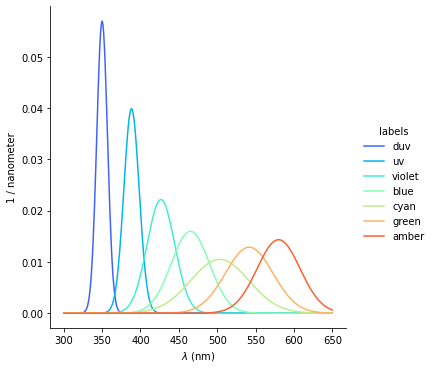

In [5]:
measured_spectra.normalized_spectra.plot(palette='rainbow')

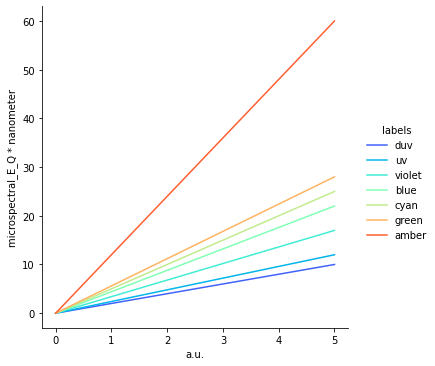

In [6]:
measured_spectra.intensities.plot(palette='rainbow')

In [7]:
# intensity range of LEDs
measured_spectra.intensity_bounds

(array([0., 0., 0., 0., 0., 0., 0.]),
 array([10., 12., 17., 22., 25., 28., 60.]))

## Trichromatic linear photoreceptor model

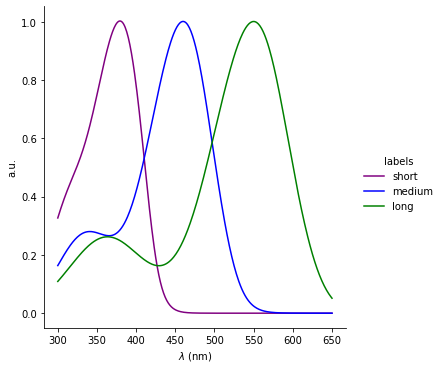

In [8]:
cmap = {'short': 'purple', 'medium': 'blue', 'long': 'green'}

sensitivity = dreye.Sensitivity(
    np.array([380, 460, 550]), 
    wls, 
    from_template=True, 
    labels=list(cmap), 
    name='opsins'
)
sensitivity.plot(palette=cmap)

photoreceptor_model = dreye.LinearPhotoreceptor(sensitivity)

In [9]:
from sklearn.decomposition import PCA
model = PCA(len(cmap))
model.fit(sensitivity.magnitude)

PCA(n_components=3)

In [10]:
model.components_

array([[-0.69234446, -0.3793454 ,  0.61380471],
       [-0.55503906,  0.82354185, -0.11709166],
       [-0.46107568, -0.42175335, -0.78072615]])

In [11]:
metrics = dreye.MeasuredSpectraMetrics([4], photoreceptor_model, measured_spectra)

In [12]:
def get_polar(X):
    CX = X @ model.components_[:, 1:]
    assert CX.shape[1] == 2, 'must assume trichromat for polar coordinates'
    sat = np.linalg.norm(CX, axis=-1)
    hue = np.arctan2(CX[:, 0], CX[:, 1])
    return np.array([sat, hue]).T

def get_saturation(X):
    return get_polar(X)[:, 0]

def get_hue(X):
    return get_polar(X)[:, 1]

def get_normalized(X):
    CX = X @ model.components_[:, 1:]
    return CX / np.linalg.norm(CX, axis=-1)[..., None]

def get_polar_space(X):
    Xa = X @ model.components_[:, :1]
    Xp = get_polar(X)
    return np.hstack([Xa, Xp])

In [13]:
Bs = pd.Series({
    'prs': np.eye(len(cmap)),
    'pcs': model.components_ / np.linalg.norm(model.components_, axis=0, ord=1),
    'achromatic': model.components_[:, :1], 
    'chromatic': model.components_[:, 1:], 
    'saturation': get_saturation, 
    'hue': get_hue, 
    'normalized': get_normalized, 
    'polar': get_polar_space
})

In [14]:
df = metrics.get_excitation_metrics(
    Bs[['prs']].to_dict(), 
    metric='mean_width',
    normalize=True
)
df_ = metrics.get_excitation_metrics(
    Bs[['hue']].to_dict(), 
    metric='jss_uniformity',
    bins=1000, range=(-np.pi, np.pi), 
    normalize=True,
)
df = pd.concat([df, df_])
df_ = metrics.get_excitation_metrics(
    Bs[['pcs']].to_dict(), 
    metric='jss_uniformity',
    bins=20,
    normalize=True,
)
df = pd.concat([df, df_])
df['lights'] = df['light_combos'].str.replace(
    '+', '\n+', regex=False
)
df['tm'] = df['transformation'] + ' -- ' + df['metric_name']

In [15]:
df_gamut = metrics.compute_gamuts()

In [17]:
df_gamut.sort_values('metric', ascending=False).head()

,duv,uv,violet,blue,cyan,green,amber,metric,light_combos,k,metric_name,transformation
22,False,True,True,True,False,False,True,0.706330,uv+violet+blue+amber,4,gamut,None
12,True,False,True,True,False,False,True,0.683121,duv+violet+blue+amber,4,gamut,None
6,True,True,False,True,False,False,True,0.680266,duv+uv+blue+amber,4,gamut,None
24,False,True,True,False,True,False,True,0.641566,uv+violet+cyan+amber,4,gamut,None
27,False,True,False,True,True,False,True,0.640715,uv+blue+cyan+amber,4,gamut,None


In [16]:
df.sort_values('metric', ascending=False).head()

,duv,uv,violet,blue,cyan,green,amber,metric,light_combos,k,metric_name,transformation,lights,tm
2,True,True,True,False,False,True,False,1.000000,duv+uv+violet+green,4,jss_uniformity,pcs,duv\n+uv\n+violet\n+green,pcs -- jss_uniformity
2,True,True,True,False,False,True,False,1.000000,duv+uv+violet+green,4,jss_uniformity,hue,duv\n+uv\n+violet\n+green,hue -- jss_uniformity
34,False,False,False,True,True,True,True,1.000000,blue+cyan+green+amber,4,mean_width,prs,blue\n+cyan\n+green\n+amber,prs -- mean_width
5,True,True,False,True,False,True,False,0.983974,duv+uv+blue+green,4,jss_uniformity,pcs,duv\n+uv\n+blue\n+green,pcs -- jss_uniformity
33,False,False,True,False,True,True,True,0.949427,violet+cyan+green+amber,4,mean_width,prs,violet\n+cyan\n+green\n+amber,prs -- mean_width


In [17]:
dfp = df.pivot(
    ['transformation', 'tm', 'metric_name'], 
    ['lights', 'light_combos'], 
    'metric'
).T
dfp.head()

,transformation,hue,pcs,prs
,tm,hue -- jss_uniformity,pcs -- jss_uniformity,prs -- mean_width
,metric_name,jss_uniformity,jss_uniformity,mean_width
lights,light_combos,,,
duv\n+uv\n+violet\n+blue,duv+uv+violet+blue,0.632443,0.499167,0.507518
duv\n+uv\n+violet\n+cyan,duv+uv+violet+cyan,0.935913,0.946649,0.501880
duv\n+uv\n+violet\n+green,duv+uv+violet+green,1.000000,1.000000,0.537329
duv\n+uv\n+violet\n+amber,duv+uv+violet+amber,0.773851,0.760513,0.728008
duv\n+uv\n+blue\n+cyan,duv+uv+blue+cyan,0.723769,0.787906,0.569726


In [18]:
argsort_metrics = np.argsort(
    np.sum(
        (
            dfp.to_numpy() 
            #* np.array([0.1, 0.9, 0.8, 0.4, 0.75])
        ), 
        axis=1
    )
)

dff = dfp.iloc[argsort_metrics]

dff = dff.iloc[:10].stack(level=[0, 1, 2])
dff.name = 'metric'
dff = dff.reset_index()
dff.head()

,lights,light_combos,transformation,tm,metric_name,metric
0,duv\n+uv\n+green\n+amber,duv+uv+green+amber,hue,hue -- jss_uniformity,jss_uniformity,0.338842
1,duv\n+uv\n+green\n+amber,duv+uv+green+amber,pcs,pcs -- jss_uniformity,jss_uniformity,0.382811
2,duv\n+uv\n+green\n+amber,duv+uv+green+amber,prs,prs -- mean_width,mean_width,0.802334
3,duv\n+uv\n+violet\n+blue,duv+uv+violet+blue,hue,hue -- jss_uniformity,jss_uniformity,0.632443
4,duv\n+uv\n+violet\n+blue,duv+uv+violet+blue,pcs,pcs -- jss_uniformity,jss_uniformity,0.499167


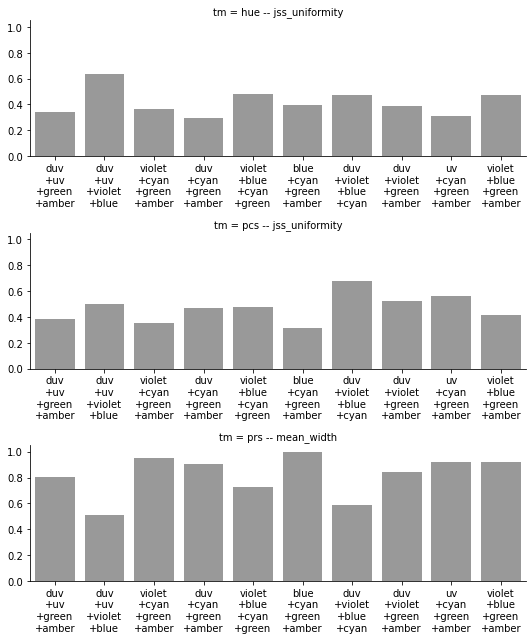

In [19]:
g = sns.FacetGrid(
    data=dff, 
    sharex=False, 
    row='tm',
    aspect=2.5
)
g.map_dataframe(
    sns.barplot, 
    x='lights', 
    y='metric',
    color='gray', 
    alpha=0.8
)

In [20]:
def get_largest_volumes(df, transformation=None, nlargest=5):
    if transformation is not None:
        df1 = df[df['transformation'] == transformation]
    else:
        df1 = df
    df2 = df1.groupby(
        ['light_combos']
    )[['metric', 'k']].mean().groupby('k')['metric'].nlargest(nlargest)
    return pd.merge(df2.reset_index()[['k', 'light_combos']], df)
largest_volumes = get_largest_volumes(df)
largest_by_prs = get_largest_volumes(df, 'prs')
largest_by_hue = get_largest_volumes(df, 'hue')
largest_by_pcs = get_largest_volumes(df, 'pcs')

In [21]:
largest_volumes.head()

,k,light_combos,duv,uv,violet,blue,cyan,green,amber,metric,metric_name,transformation,lights,tm
0,4,duv+uv+violet+green,True,True,True,False,False,True,False,0.537329,mean_width,prs,duv\n+uv\n+violet\n+green,prs -- mean_width
1,4,duv+uv+violet+green,True,True,True,False,False,True,False,1.000000,jss_uniformity,hue,duv\n+uv\n+violet\n+green,hue -- jss_uniformity
2,4,duv+uv+violet+green,True,True,True,False,False,True,False,1.000000,jss_uniformity,pcs,duv\n+uv\n+violet\n+green,pcs -- jss_uniformity
3,4,duv+uv+blue+green,True,True,False,True,False,True,False,0.598913,mean_width,prs,duv\n+uv\n+blue\n+green,prs -- mean_width
4,4,duv+uv+blue+green,True,True,False,True,False,True,False,0.867239,jss_uniformity,hue,duv\n+uv\n+blue\n+green,hue -- jss_uniformity


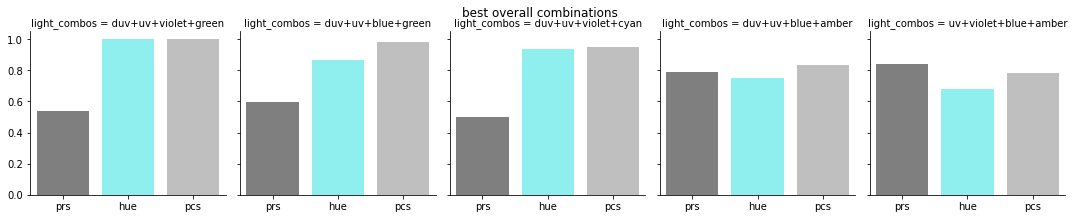

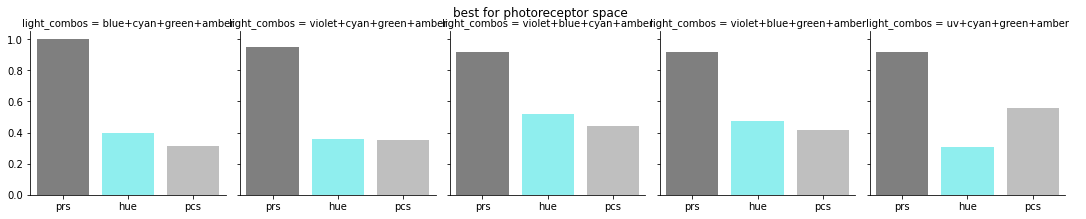

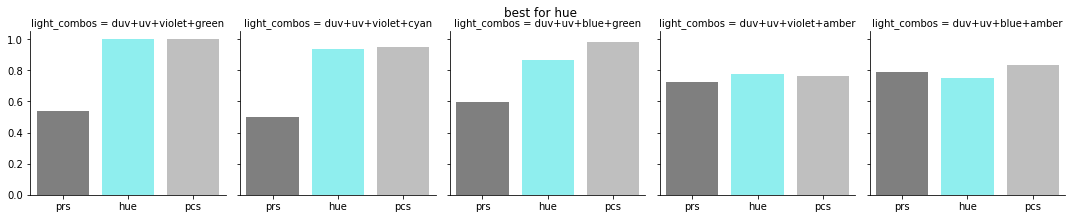

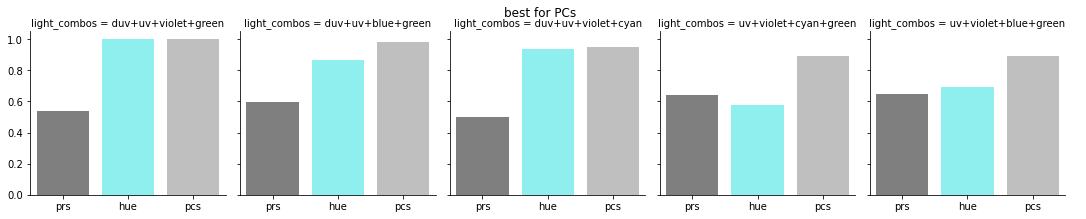

In [22]:
def plot_largest_volumes(df, title=''):
    g = sns.FacetGrid(
        data=df, 
        sharex=False,
        sharey=True,
        aspect=1, 
        col='light_combos'
    )

    g.map_dataframe(
        sns.barplot, 
        x='transformation', 
        y='metric', 
        # hue='transformation',
        alpha=0.5, 
        palette={
            'achromatic': 'gray', 
            'prs': 'black', 
            'chromatic': 'deeppink', 
            'hue': 'cyan', 
            'saturation': 'tomato', 
            'polar': 'gold', 
            'normalized': 'navy', 
            'pcs': 'gray'
        },
    ).add_legend()
    plt.suptitle(title, y=1)
    
plot_largest_volumes(largest_volumes, 'best overall combinations')
plot_largest_volumes(largest_by_prs, 'best for photoreceptor space')
plot_largest_volumes(largest_by_hue, 'best for hue')
plot_largest_volumes(largest_by_pcs, 'best for PCs')

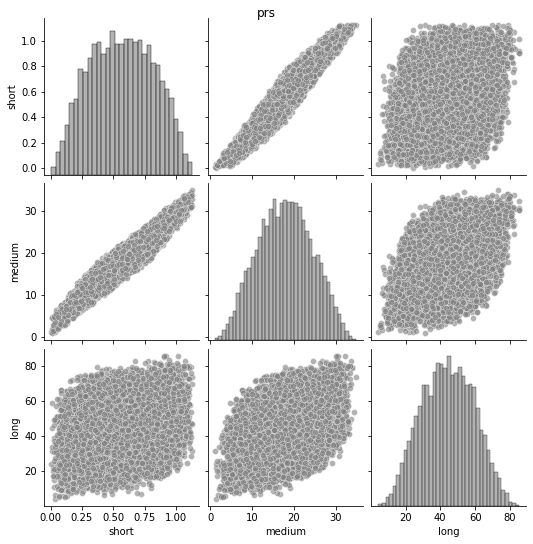

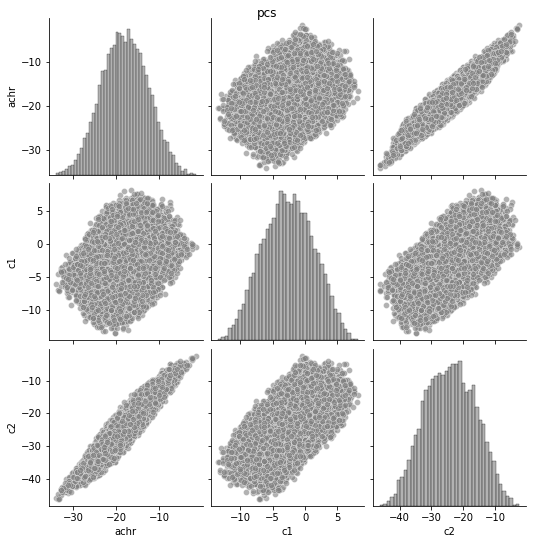

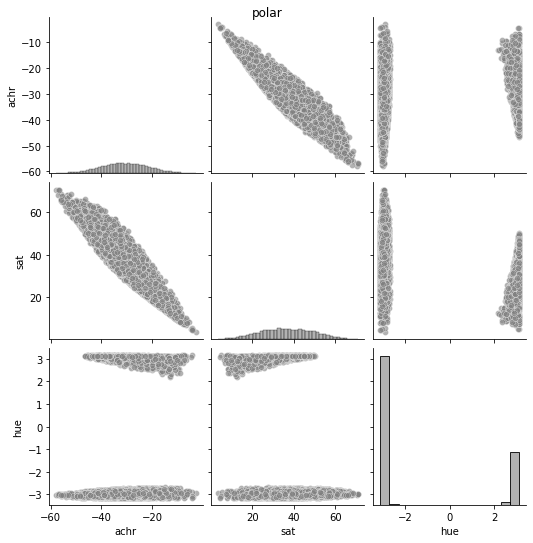

In [24]:
metrics.plot_excitation_points(
    'blue+cyan+green+amber', 
    B=Bs[['prs', 'pcs', 'polar']].to_dict(), 
    B_columns={
        'prs': list(cmap), 
        'pcs': ['achr', 'c1', 'c2'], 
        'polar': ['achr', 'sat', 'hue']
    }
)